# Task 2 - Filtro de Spam Bayesiano
El objetivo es construir un clasificador de texto probabilístico desde cero.  El dataset para trabajar consiste en un texto donde cada línea es ETIQUETA \t MENSAJE, cargado desde `spam.txt`.

### Prompts

Cumpliendo con las reglas del laboratorio, utilicé IA generativa para generar las gráficas con Matplotlib / Seaborn. Los prompts consisten en:

[Contexto] Eg. I have a weight vector w_final, a bias b_final, and two DFs of training values x_train and y_train.

[Task] Eg. I need to graph the 2D points from x_train colored by y_train (binary classification) as there's going to be concentric points. Then, I'll need to graph the decision boundary for the model on top of it.

Esto funciona porque se explica al inicio los objetos con los que se están trabajando, así se evitan errores de compatibilidad etc. Adicionalmente, siendo descriptivos y concretos con el task se deja poca "interpretabilidad" donde la IA pueda tomar alguna decisión "tonta".

Adicionalmente, al ir iterando busco ser lo más específico posible con los objetos que se están trabajando o dar alguna guía lo más "bajo nivel posible". Por ejemplo,

"I'll need the plot to fill the background above / under the decision threshold to identify the positive / negative class, no other changes"

También, como preferencia personal hago la mayoría de cosas "a manita" pero ocupo la ayuda ocasional para recordar sintaxis / documentación. No pretendo que conozco todas las operaciones de álgebra lineal de Numpy, pero colocar un prompt dónde pregunto "cómo se calculaban normas en Numpy" se me hace un poco overkill :)

## 1. Pre Procesamiento

### Carga del Archivo
Primero, podemos cargar el archivo a una lista de strings para verificar que se haya leído correctamente.

In [30]:
with open('data/spam.txt', 'r') as file:
    lines = file.readlines()

for i in range(3):
    print(lines[i])

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Limpieza de Texto
Aquí aplicamos las operaciones de conversión a minúsculas, removiendo caracteres especiales y manteniendo únicamente palabras por si solas. Por decisión de diseño, estaremos removiendo completamente los números. Adicionalmente, estaremos indagando sobre caracteres especiales y que rol pueden posiblemente jugar. Por ejemplo, un signo de dolar se "perdería" en traducción pero podríamos encodearlo a una palabra diferente.

In [31]:
from collections import Counter
import re

# Buscar todos los símbolos e imprimirlos
all_text = " ".join(lines)
symbols_only = re.findall(r'[^a-zA-Z0-9\s]', all_text)
print(Counter(symbols_only).most_common())

[('.', 11042), (',', 1938), ("'", 1829), ('?', 1546), ('!', 1387), ('&', 867), (':', 738), (';', 713), ('-', 581), (')', 499), ('/', 418), ('"', 344), ('£', 329), ('*', 311), ('#', 261), ('+', 137), ('ü', 120), ('(', 119), ('Ü', 53), ('=', 47), ('\x92', 39), ('@', 38), ('‘', 37), ('|', 36), ('>', 31), ('$', 22), ('…', 16), ('_', 15), ('%', 10), ('–', 9), ('<', 6), ('[', 5), (']', 5), ('\\', 4), ('\x94', 4), ('~', 3), ('’', 3), ('\x96', 3), ('é', 3), ('“', 2), ('\x91', 2), ('\x93', 2), ('¡', 2), ('ú', 1), ('è', 1), ('^', 1), ('»', 1), ('—', 1), ('É', 1), ('ì', 1), ('鈥', 1), ('┾', 1), ('〨', 1)]


De los símbolos vistos, podríamos teorizar que los siguientes pueden tener significancia: `?`, `!`, `£`, `#`, `+`, `ü`, `ú`, `é`, `É`, `@`, `$`, `%`.

Adicionalmente, algunos de estos tienen pocas apariciones y podrían agruparse juntos; por ejemplo, `ü`, `ú`, `é`, `É` pueden agruparse como caracteres especiales.

Vamos a definir las siguientes **"clases"** para el encoding:

| Símbolo | Token (Clase) |
| :--- | :--- |
| `$`, `£`, `€` | `tagmoney` |
| `ü`, `ú`, `é`, `É` | `tagchar` |
| `!` | `tagexclamation` |
| `?` | `tagquestion` |
| `#`, `+` | `tagcontact` |
| `%` | `tagpercent` |
| `@` | `tagat` |

In [32]:
import pandas as pd
import re

processed_lines = []

# Mapa de símbolos
symbol_map = {
    '$': ' tagmoney ',
    '£': ' tagmoney ',
    '€': ' tagmoney ',
    'ü': ' tagchar ',
    'ú': ' tagchar ',
    'é': ' tagchar ',
    'É': ' tagchar ',
    '!': ' tagexclamation ',
    '?': ' tagquestion ',
    '#': ' tagcontact ',
    '+': ' tagcontact ',
    '%': ' tagpercent ',
    '@': ' tagat '
}

for line in lines:

    # Reemplazar números por tagnumber
    line = re.sub(r'\d+', ' tagnumber ', line)

    # Reemplazar símbolos por su valor en el mapa
    for symbol, token in symbol_map.items():
        line = line.replace(symbol, token)
    
    # Reemplazar los demás símbolos por blanks
    line = re.sub(r'[^a-z\s]', '', line.lower())

    processed_lines.append(line)

for i in range(5):
    print(processed_lines[i])

ham	go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat

ham	ok lar joking wif u oni

spam	free entry in  tagnumber  a wkly comp to win fa cup final tkts  tagnumber st may  tagnumber  text fa to  tagnumber  to receive entry questionstd txt ratetcs apply  tagnumber over tagnumber s

ham	u dun say so early hor u c already then say

ham	nah i dont think he goes to usf he lives around here though



### Generación de Vocabulario
Aquí podemos simplemente utilizar list (set?) comprehension sobre cada línea, dónde separamos la línea por espacios en blanco ignorando el primer índice (el tag de spam o ham).

In [33]:
vocab = {word for line in processed_lines for word in line.split()[1:]}
print(f"Vocabulary Size: {len(vocab)}")

Vocabulary Size: 8441


## 2. Entrenamiento

### Priors
Primero, podemos empezar construyendo los 'bancos' de palabras para cada una de nuestras clases. Luego, simplemente tomando las proporciones de Spam y Ham respectivamente.

In [ ]:
import pandas as pd

spam_words = []
ham_words = []
n_spam = 0
n_ham = 0

for line in processed_lines:
    words = line.split()
    
    label = words[0]
    content = words[1:]
    
    if label == 'spam':
        spam_words.extend(content)
        n_spam += 1
    else:
        ham_words.extend(words)
        n_ham += 1

# P(Clase) = n_clase / n_total
p_spam = n_spam / len(processed_lines)
p_ham = n_ham / len(processed_lines)

### Likelyhoods
Aquí podemos utilizar Counter para crear un diccionario de frecuencias de cada una de las palabras y utilizando las tablas de frecuencia calcular las likelihoods utilizando Laplace Smoothing.

In [ ]:
import pandas as pd
from collections import Counter

# Crear tablas de frecuencia
spam_counts = Counter(spam_words)
ham_counts = Counter(ham_words)

# Definir k y tamaño del vocabulario
k = 1 
vocab_size = len(vocab)

# Definir la cantidad de palabras únicas en cada 
total_spam_words = len(spam_words)
total_ham_words = len(ham_words)

# Lookup table para nuestros likelyhoods
likelihoods = {}

for word in vocab:    
    # Calcular probabilidad de la palabra dado que es Spam. P(wi|Spam)
    p_w_spam = (spam_counts[word] + k) / (total_spam_words + k * vocab_size)
    
    # Calcular probabilidad de la palabra dado que es Ham. P(wi|Ham)
    p_w_ham = (ham_counts[word] + k) / (total_ham_words + k * vocab_size)
    
    # Almacenar en lookup table
    likelihoods[word] = {
        'p_spam': p_w_spam,
        'p_ham': p_w_ham
    }

## 3. Inferencia
Ahora podemos construir nuestra función para predecir, debemos de tener en cuenta que debemos aplicarle exactamente los mismos pasos de limpieza que realizamos anteriormente.

In [36]:
import numpy as np

def predict(message):
    # Reemplazar números por tagnumber
    message = re.sub(r'\d+', ' tagnumber ', message)
    
    # Reemplazar símbolos por su valor en el mapa
    for symbol, token in symbol_map.items():
        message = message.replace(symbol, token)
        
    # Reemplazar los demás símbolos por blanks
    message = re.sub(r'[^a-z\s]', '', message.lower())

    # Tokenizar
    tokens = message.split()

    # Inicializar Priors (usando log para evitar underflow)
    score_spam = np.log(p_spam)
    score_ham = np.log(p_ham)

    # Calcular probabilidad cumulativa
    for word in tokens:
        if word in likelihoods:
            score_spam += np.log(likelihoods[word]['p_spam'])
            score_ham += np.log(likelihoods[word]['p_ham'])

    # Retornar probabilidad más alta
    if score_spam > score_ham:
        return 'spam'
    else:
        return 'ham'

## 4. Evaluación
En teoría, la separación tuvo que realizarse desde un principio ya que tenemos información del conjunto de prueba al entrenar nuestro modelo. Sin embargo, dentro del laboratorio nos indica realizarlo dentro del inciso 4 y tendría que re-nombrar variables a lo largo del Notebook para cambiarlo.

### Separación en Test - Train
Empezamos utilizando un stratified split de SKLearn para separar los datos 80-20

In [37]:
from sklearn.model_selection import train_test_split

messages = []
labels = []

# Separar cada línea en label y contenido
for line in processed_lines:
    parts = line.split()
    if not parts: continue
    
    labels.append(parts[0])
    messages.append(" ".join(parts[1:]))

# Separar en train - test con split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    messages, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

print(f"Training Data: {len(X_train)} samples")
print(f"Testing Data: {len(X_test)} samples")

Training Data: 4452 samples
Testing Data: 1113 samples


Ahora, podemos evaluar el conjunto de prueba y graficar la matriz de confusión

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       964
        spam       0.93      0.98      0.95       149

    accuracy                           0.99      1113
   macro avg       0.96      0.98      0.97      1113
weighted avg       0.99      0.99      0.99      1113



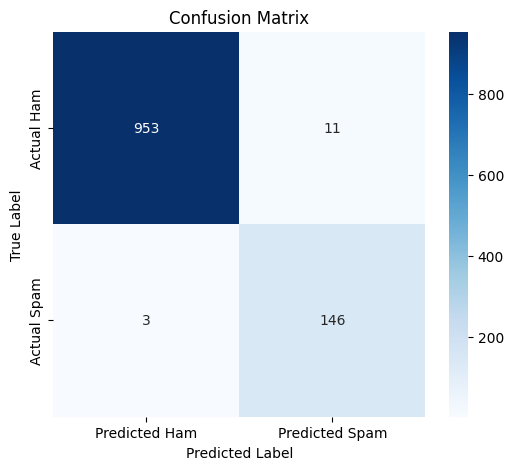

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = [predict(msg) for msg in X_test]

print(classification_report(y_test, y_pred, labels=['ham', 'spam']))

cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Aunque el modelo presenta un accuracy elevado, clasificando erróneamente solo 14 de 1113 mensajes, es crucial analizar el impacto de estos errores en un contexto real. Observamos que 11 correos legítimos (Ham) fueron incorrectamente clasificados como Spam (Falsos Positivos). En un filtro de correo, este es el error más costoso, pues implica la pérdida de información relevante para el usuario. Por tanto, el objetivo debe ser maximizar la Precisión de la clase Spam (en lugar del Recall), ajustando los thresholds de decisión para volver el modelo más conservador y garantizar que los correos legítimos lleguen a la bandeja de entrada.

### Extra Tuning
Como experimentación adicional, voy a "mover" un poco la función de predicción para buscar minimizar los falsos positivos.

In [ ]:
def predict(message, threshold=10):
    message = re.sub(r'\d+', ' tagnumber ', message)
    for symbol, token in symbol_map.items():
        message = message.replace(symbol, token)
    message = re.sub(r'[^a-z\s]', '', message.lower())
    tokens = message.split()

    score_spam = np.log(p_spam)
    score_ham = np.log(p_ham)

    for word in tokens:
        if word in likelihoods:
            score_spam += np.log(likelihoods[word]['p_spam'])
            score_ham += np.log(likelihoods[word]['p_ham'])

    # Solo decimos que es SPAM si supera al HAM + threshold
    if score_spam > (score_ham + threshold):
        return 'spam'
    else:
        return 'ham'

Ahora podemos ver el desempeño en el conjunto de prueba

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       964
        spam       0.99      0.89      0.94       149

    accuracy                           0.98      1113
   macro avg       0.99      0.94      0.96      1113
weighted avg       0.98      0.98      0.98      1113



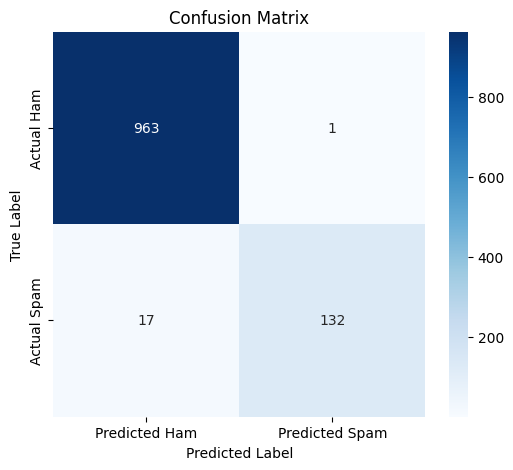

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = [predict(msg) for msg in X_test]

print(classification_report(y_test, y_pred, labels=['ham', 'spam']))

cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Podemos ver que el modelo técnicamente empeoró, esta vez con 18 casos clasificados incorrectamente. Sin embargo, únicamente tenemos 1 "correo perdido". Esto nos indica que el modelo a pesar de tener un accuracy disminuido es mejor resolviendo el problema de la vida real. Lo más adecuado sería seguir experimentando con los thresholds, posiblemente otros métodos de encoding o búsqueda de un dataset más grande.